# Comparison Model 
## Import Important Libraries

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# Function to evaluate a model

In [20]:
def evaluate_model(model, X_test, y_test, y_probs):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_probs)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return accuracy, roc_auc, precision, recall, f1

# Load the dataset

In [22]:
file_path = 'D:Downloads/iiot_30min_norm.csv'
df = pd.read_csv(file_path)

# Feature Engineering: Create lag features and rolling statistics

In [24]:
df['FM1_rolling_mean'] = df['FM1'].rolling(window=3).mean()
df['FM1_lag_1'] = df['FM1'].shift(1)
df['FM1_lag_2'] = df['FM1'].shift(2)
df['hour'] = pd.to_datetime(df['TIME']).dt.hour
df['day'] = pd.to_datetime(df['TIME']).dt.day

# Create a new target variable combining FM1 and PE1

In [26]:
failure_threshold_fm1 = df['FM1'].quantile(0.05)
failure_threshold_pe1 = df['PE1'].quantile(0.05)

# Define failure if either FM1 or PE1 drops below their respective thresholds

In [33]:
df['new_target'] = (
    (df['FM1'].rolling(window=5).min() < failure_threshold_fm1) |
    (df['PE1'].rolling(window=5).min() < failure_threshold_pe1)
).astype(int)

# Shift the new target for predictive maintenance

In [36]:
df['new_target'] = df['new_target'].shift(-5).fillna(0).astype(int)

In [38]:
# Drop rows with NaN values
df = df.dropna()

# Define features and the new target
X = df[['FM1', 'FM1_rolling_mean', 'FM1_lag_1', 'FM1_lag_2', 'hour', 'day', 'PE1', 'PE2']]
y = df['new_target']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# Initialize the models (SVM, RF AND K-NN)

In [41]:
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')
svm_model = SVC(kernel='rbf', class_weight='balanced', probability=True, random_state=42)
knn_model = KNeighborsClassifier(n_neighbors=5)

# Train and evaluate Random Forest

In [44]:
rf_model.fit(X_train, y_train)
y_probs_rf = rf_model.predict_proba(X_test)[:, 1]
rf_accuracy, rf_roc_auc, rf_precision, rf_recall, rf_f1 = evaluate_model(rf_model, X_test, y_test, y_probs_rf)

# Train and evaluate SVM

In [47]:
svm_model.fit(X_train, y_train)
y_probs_svm = svm_model.predict_proba(X_test)[:, 1]
svm_accuracy, svm_roc_auc, svm_precision, svm_recall, svm_f1 = evaluate_model(svm_model, X_test, y_test, y_probs_svm)

# Train and evaluate k-NN

In [50]:
knn_model.fit(X_train, y_train)
y_probs_knn = knn_model.predict_proba(X_test)[:, 1]
knn_accuracy, knn_roc_auc, knn_precision, knn_recall, knn_f1 = evaluate_model(knn_model, X_test, y_test, y_probs_knn)

# Create a DataFrame for the comparison matrix

In [53]:
comparison_df = pd.DataFrame({
    'Model': ['Random Forest', 'SVM', 'k-NN'],
    'Accuracy': [rf_accuracy, svm_accuracy, knn_accuracy],
    'ROC AUC': [rf_roc_auc, svm_roc_auc, knn_roc_auc],
    'Precision': [rf_precision, svm_precision, knn_precision],
    'Recall': [rf_recall, svm_recall, knn_recall],
    'F1 Score': [rf_f1, svm_f1, knn_f1]
})

# Display the comparison matrix

In [56]:
print(comparison_df)

           Model  Accuracy   ROC AUC  Precision    Recall  F1 Score
0  Random Forest  0.931818  0.976818   0.935780  0.927273  0.931507
1            SVM  0.840909  0.907355   0.837838  0.845455  0.841629
2           k-NN  0.945455  0.982645   0.908333  0.990909  0.947826


# Plotting the comparison matrix

C:\Users\Pc Planet\AppData\Local\Temp\ipykernel_4288\289134928.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y=metric, data=comparison_df, palette='viridis')


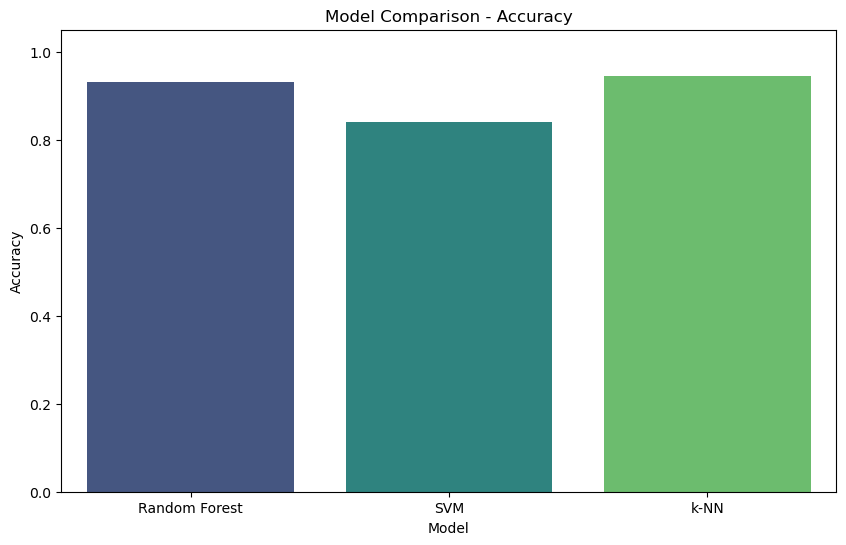

C:\Users\Pc Planet\AppData\Local\Temp\ipykernel_4288\289134928.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y=metric, data=comparison_df, palette='viridis')


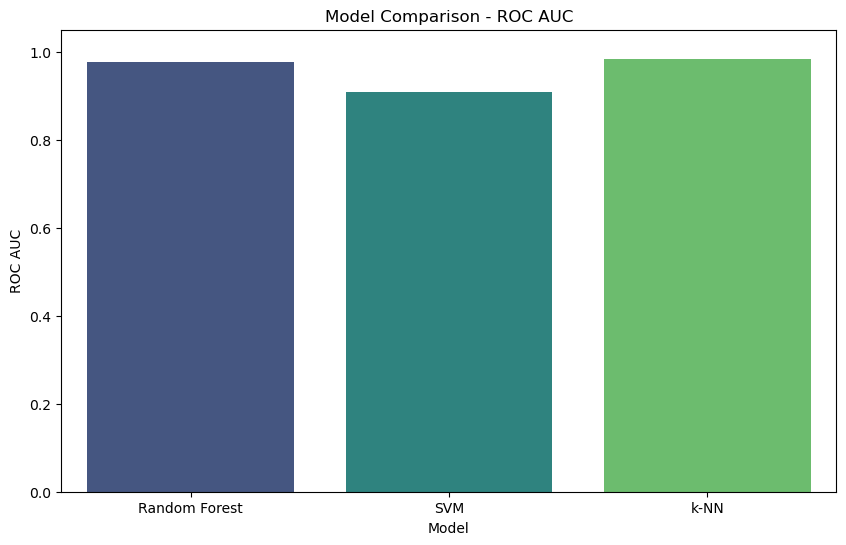

C:\Users\Pc Planet\AppData\Local\Temp\ipykernel_4288\289134928.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y=metric, data=comparison_df, palette='viridis')


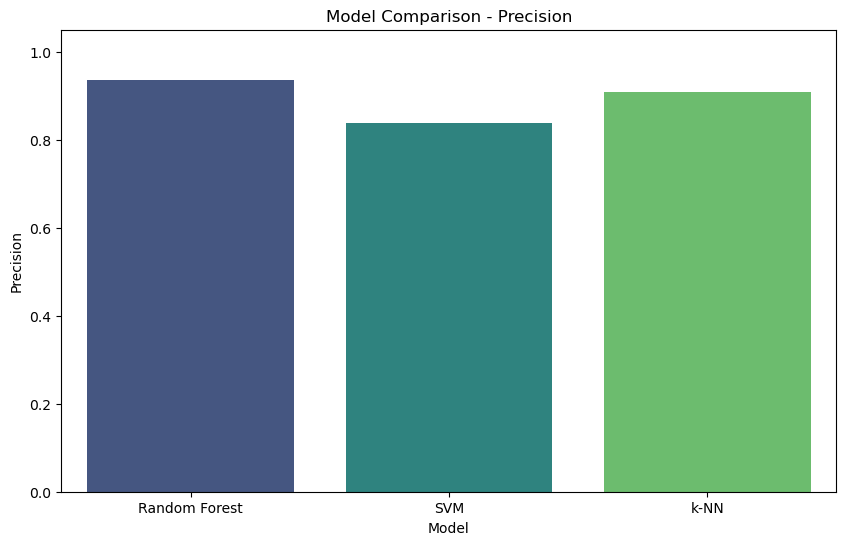

C:\Users\Pc Planet\AppData\Local\Temp\ipykernel_4288\289134928.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y=metric, data=comparison_df, palette='viridis')


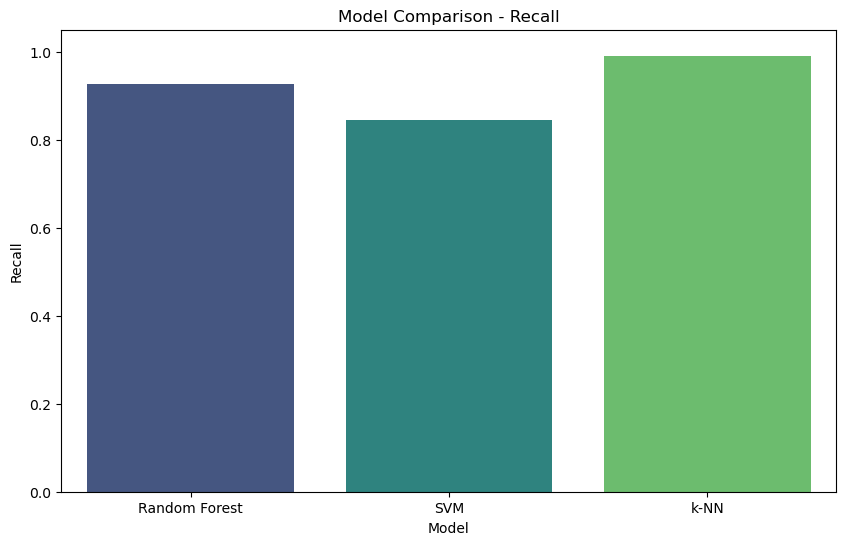

C:\Users\Pc Planet\AppData\Local\Temp\ipykernel_4288\289134928.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y=metric, data=comparison_df, palette='viridis')


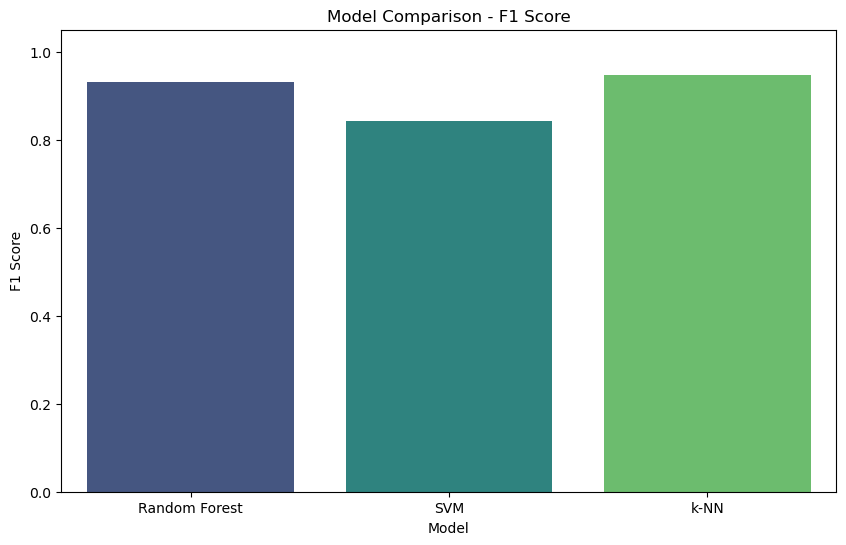

In [64]:
metrics = ['Accuracy', 'ROC AUC', 'Precision', 'Recall', 'F1 Score']

for metric in metrics:
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Model', y=metric, data=comparison_df, palette='viridis')
    plt.title(f'Model Comparison - {metric}')
    plt.ylabel(metric)
    plt.ylim(0, 1.05)
    plt.show()

# Plotting the ROC curves for all models

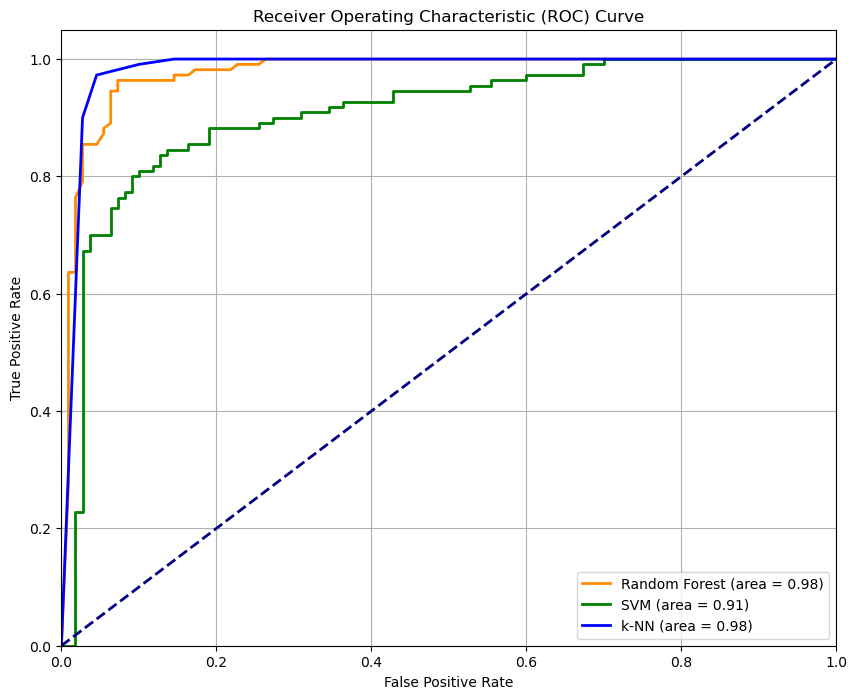

In [67]:
plt.figure(figsize=(10, 8))
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_probs_rf)
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_probs_svm)
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_probs_knn)

plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label='Random Forest (area = {:.2f})'.format(rf_roc_auc))
plt.plot(fpr_svm, tpr_svm, color='green', lw=2, label='SVM (area = {:.2f})'.format(svm_roc_auc))
plt.plot(fpr_knn, tpr_knn, color='blue', lw=2, label='k-NN (area = {:.2f})'.format(knn_roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()